In [13]:
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool
from itertools import repeat

from definitions import ROOT_DIR
from unc.utils import load_info

In [20]:
uf2m_u_color = 'darkorange'

all_paths = {
    'uf2a_cnn': Path(ROOT_DIR, 'results', 'uf2a_cnn'),
    'uf2m_cnn':  Path(ROOT_DIR, 'results', 'uf2m_cnn'),
    'uf2p_cnn_lstm':  Path(ROOT_DIR, 'results', 'uf2p_cnn_lstm'),
    'uf2m_cnn_lstm':  Path(ROOT_DIR, 'results', 'uf2m_cnn_lstm'),

}

plot_info = {
    'uf2a_cnn': {'color': 'forestgreen', 'label': 'Ground-truth map'},
    'uf2p_cnn_lstm': {'color': 'lightcoral', 'label': 'LSTM + observations'},
    'uf2m_cnn_lstm': {'color': 'darkred', 'label': 'LSTM + normal mapping'},
    'uf2m_cnn_uncertainty_decay_1.0': {'color': 'black', 'label': 'Normal mapping'},
    'uf2m_cnn_uncertainty_decay_0.9': {'color': 'darkorange', 'label': 'Normal mapping + uncertainty'}
}

plot_order = [
    'uf2a_cnn',
    'uf2m_cnn_uncertainty_decay_1.0',
    'uf2p_cnn_lstm',
    'uf2m_cnn_lstm',
    'uf2m_cnn_uncertainty_decay_0.9'
]
split_by = ['buffer_size', 'step_size', 'arch', 'uncertainty_decay']
Args = namedtuple('args', split_by)


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [21]:
def process_dir(dir_path, split_by, w=10):
    all_results = {}

        
    for f in tqdm(list(dir_path.iterdir())):
        info = load_info(f)
        args = info['args'].item()
        if "arch" not in args:
            args['arch'] = 'nn'
        
        reward = info['reward']
        offline_returns = info['offline_eval_returns']

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

        all_results[hparams].append((reward, offline_returns, args, f))

    
    return all_results

    

In [22]:
def group_by(dataset, key, label_head, arrayify=True):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)
        full_label = label_head + f'_{key}_{key_val}'
        if full_label not in grouped_data:
            grouped_data[full_label] = {}
        
        grouped_data[full_label][args] = d
    return grouped_data

In [23]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    raw_data[key] = processed

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

In [24]:
key = 'uncertainty_decay'
split_file = 'uf2m_cnn'
uf2m_grouped = group_by(raw_data[split_file], key, split_file)

In [25]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data.items():
        final_max = np.mean([np.mean(offline_rew) for online_rew, offline_rew, all_args, fname in all_dis_rew])
        fnames = [fname for _, _, _, fname in all_dis_rew]
        hparam_results.append((args, final_max, fnames))
    return hparam_results



In [26]:
new_raw = {}
for k, v in uf2m_grouped.items():
    new_raw[k] = v

for k, v in raw_data.items():
    if k != split_file:
        new_raw[k] = v

In [27]:
max_overs = {}
for g, v in new_raw.items():
    max_overs[g] = get_eps_max_over(v, eps_max_over=100)

In [28]:
# Get the best hyperparams based on the final 100 episodes
all_best = {}
for key, v in max_overs.items():
    all_best[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

all_best

{'uf2m_cnn_uncertainty_decay_0.9': (args(buffer_size=100000, step_size=0.001, arch='cnn', uncertainty_decay=0.9),
  35.35124,
  [PosixPath('/home/taodav/Documents/uncertainty/results/uf2m_cnn/c9137a321ed692ba3a24ac1c1f74f9d0_Mon May  2 16:32:08 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results/uf2m_cnn/284e581cdf3c6ef5b5a26c39ee17fb75_Mon May  2 16:38:12 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results/uf2m_cnn/87ee4fca689071e28301986f2a70dfc6_Mon May  2 13:34:45 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results/uf2m_cnn/65787e7360f6c4563c9f786d581e6437_Mon May  2 16:32:08 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results/uf2m_cnn/0a91f6df2b60df31db71a5b264ed5657_Mon May  2 16:38:12 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results/uf2m_cnn/53a1f0a14e3a570f0acb875a1dfbd6a2_Fri Apr 29 18:18:51 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results/uf2m_cnn/4e9f63f5a43e15a99f5fdd

In [29]:
# alg_dir_map = {
#     'uf2m_cnn_uncertainty_decay_0.9': 'uf2m_cnn',
#     'uf2m_cnn_uncertainty_decay_1.0': 'uf2m_cnn',
#     'uf2a_cnn': 'uf2a_cnn',
#     'uf2p_cnn_lstm': 'uf2p_cnn_lstm',
#     'uf2m_cnn_lstm': 'uf2m_cnn_lstm'
# }
# for alg, values in all_best.items():
#     arg, offline_mean, fnames = values
#     results_dir = Path(ROOT_DIR, 'results')
#     dir_to_append = results_dir / alg_dir_map[alg]

#     for f in fnames:
#         shutil.copy(f, dir_to_append)
    
    

In [30]:
# Now we map our discounted episodic rewards back to steps. We assign the discounted reward achieved at the 
# end of and episode to each timestep within the episode


# def map_dis_rew_to_steps(data, w=1000, trunc=1e6):
#     all_seeds = []
#     for offline_rews, online_rews, _ in data:
#         current_seed = []
#         for length, dis_rew in zip(lengths, dis_rews):
#             current_seed.append(np.zeros(length) + dis_rew)
#         all_seeds.append(moving_avg(np.concatenate(current_seed)[:trunc], w=w))
#     return np.array(all_seeds)

In [31]:
# trunc = int(1e6)
all_mapped_data = {}
for key, v in all_best.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in new_raw[key][arg]]
    all_mapped_data[key] = np.stack(all_seeds)



In [32]:
all_mapped_data

{'uf2m_cnn_uncertainty_decay_0.9': array([[14.4, 15.6, 17.6, ..., 35.8, 33.4, 36.6],
        [10.2,  8.6, 12.8, ..., 37.2, 37.2, 39.6],
        [ 9.4, 14.4, 13.8, ..., 36.2, 37.2, 37.6],
        ...,
        [11. , 13.6, 16. , ..., 41.4, 36.6, 35.6],
        [11.2, 13.8, 13.8, ..., 37.6, 36.8, 36.6],
        [ 9.8, 11.4, 10.4, ..., 36.2, 37.6, 38.8]]),
 'uf2m_cnn_uncertainty_decay_1.0': array([[ 9. ,  8.2, 10.2, ..., 31.8, 33.8, 36.4],
        [ 8.2,  9.2, 12.2, ..., 29.8, 25.8, 33.4],
        [ 6. , 11.6, 13.6, ..., 28.8, 32.2, 30.4],
        ...,
        [13.2, 13.6, 13.6, ..., 35.8, 31.4, 24.8],
        [ 7.2, 15.8, 13.2, ..., 28. , 29.2, 34.8],
        [ 7.4,  8.2, 11. , ..., 29.8, 34.8, 35. ]]),
 'uf2a_cnn': array([[12.4, 16.8, 14. , ..., 44.6, 42.2, 45. ],
        [16.2, 15. , 21.4, ..., 46.4, 43.4, 40.8],
        [11.8, 12.8, 13.6, ..., 42. , 46. , 48.6],
        ...,
        [11.4, 16. , 13.4, ..., 46.6, 44.2, 44.2],
        [15. , 16.8, 13.2, ..., 40.2, 44.4, 40.6],
        [1

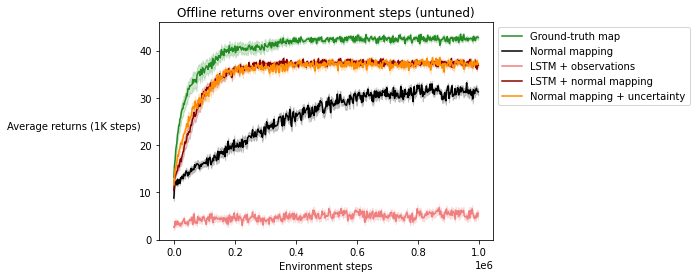

In [33]:
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k in plot_order:
    data = all_mapped_data[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (untuned)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

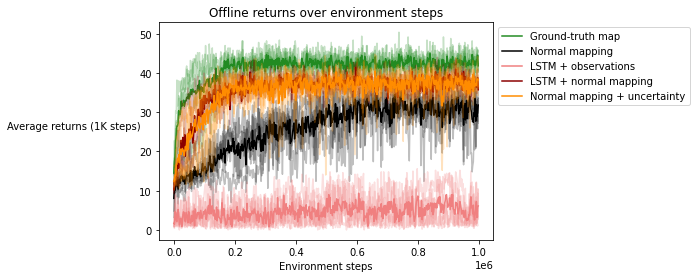

In [61]:
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k in plot_order:
    data = all_mapped_data[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0) 

    ax.plot(x, means, label=key, color=color)
    for d in data:
        ax.plot(x, d, color=color, alpha=0.25)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')